<a href="https://colab.research.google.com/github/guilhembr/Clustering-Client/blob/main/POlist_02_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clustering on Olist e-commerce Database

Data Source : https://www.kaggle.com/olistbr/brazilian-ecommerce/version/7?select=product_category_name_translation.csv

In [ ]:
#Verify latests versions of packages
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.2

!pip install squarify
!pip install -U yellowbrick
!pip install plotly==5.3.1
!pip install dash

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 6.8 MB 5.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
     |████████████████████████████████| 23.9 MB 14 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 7.3 MB 5.1 MB/s 
     |████████████████████████████████| 357 kB 78.3 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=a32884485863e2ddfbc7fb4576ce71078c0ab0fe06c6087540f8345474825a2e
  Stored in directory: /root/.ca

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import numpy as np
from scipy import stats

#Viz libraries
import plotly.express as px
import plotly.graph_objects as go

#Standard ML librairies import
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

#Clustering librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

matplotlib.rcParams["figure.figsize"] = (12, 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#project custom scripts
import sys
import os

py_file_location = "/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 5/Notebooks/"
sys.path.append(os.path.abspath(py_file_location))

import olist_functions as custom

##Import the Data

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/3_Projets OC/Projet 5/raw data/'

# Orders
orders_raw = pd.read_csv(root_dir + 'olist_orders_dataset_cleaned.csv',
                         parse_dates=['order_purchase_timestamp',
                                      'order_approved_at',
                                      'order_delivered_carrier_date',
                                      'order_delivered_customer_date',
                                      'order_estimated_delivery_date'])

# Customers
customers_raw = pd.read_csv(root_dir + 'olist_customers_dataset.csv',
                            dtype={'customer_zip_code_prefix': str})

# Payments
payments_raw = pd.read_csv(root_dir + 'olist_order_payments_dataset.csv')

# Reviews
reviews_raw = pd.read_csv(root_dir + 'olist_order_reviews_dataset.csv',
                          parse_dates=['review_creation_date',
                                       'review_answer_timestamp'])

# Orders details
order_items_raw = pd.read_csv(root_dir + 'olist_order_items_dataset.csv',
                              parse_dates=['shipping_limit_date'],
                              dtype={'order_item_id': float})

# Products
products_portuguese_raw = pd.read_csv(root_dir + 'olist_products_dataset.csv')

# Sellers
sellers_raw = pd.read_csv(root_dir + 'olist_sellers_dataset.csv')

# Geo
geolocation_raw = pd.read_csv(root_dir + 'olist_geolocation_dataset.csv',
                              dtype={'geolocation_zip_code_prefix': str})

# Categs
categ_prod_file = root_dir + 'product_category_name_translation.csv'
product_category_translate = pd.read_csv(categ_prod_file)

#Manual RFM Clustering

In [ ]:
customers_raw

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,03937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,06764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


We want to join 3 datasets in order to calculate RFM : 
* Recency : 
  * How long has it been since the client's last activity?
  * Info needed : `point in time on which the analysis will be based` `order date` `customer id`

* Frequency : 
  * Over a given period of time, how many times has a customer purchased or interacted with the brand?
  * Info needed : `point in time on which the analysis will be based` `customer id` `order count` 

* Monetary : 
  * How much money did a customer spend in a given period of time?
  * Info needed : `customer id` `order count` `order individual amount`

First let's join the `order dataset` and the `customer dataset` in order to obtain the `customer_unique_id`. 

In [ ]:
merge_cust_orders = orders_raw.merge(customers_raw.iloc[:, :2], on='customer_id')
merge_cust_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours,order_approved_date,order_delivery_carrier_date,order_delivery_customer_estimated,order_delivery_customer_date,placing_daylag,shipping_daylag,estimation_daylag,carrier_daylag,delivery_timing,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning,20171002,20171004,20171018,20171010,0,2,-8,6,8,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening,20180726,20180726,20180813,20180807,2,0,-6,81,13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning,20180808,20180808,20180904,20180817,0,0,-87,9,9,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,Evening,20171118,20171122,20171215,20171202,0,4,-13,80,13,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,Evening,20180213,20180214,20180226,20180216,0,1,-10,2,2,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93120,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,Mar,201703,20170309,9,3,Thu,Morning,20170309,20170310,20170328,20170317,0,1,-11,7,8,6359f309b166b0196dbf7ad2ac62bb5a
93121,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,Feb,201802,20180206,6,1,Tue,Afternoon,20180206,20180207,20180302,20180228,0,1,-74,21,22,da62f9e57a76d978d02ab5362c509660
93122,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017,8,Aug,201708,20170827,27,6,Sun,Afternoon,20170827,20170828,20170927,20170921,0,1,-6,93,24,737520a9aad80b3fbbdad19b66b37b30
93123,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,Jan,201801,20180108,8,0,Mon,Evening,20180108,20180112,20180215,20180125,0,4,-90,13,17,5097a5312c8b157bb7be58ae360ef43c


## KPI Calculation

### Recency

In [ ]:
orders_raw.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_year', 'order_purchase_month',
       'order_purchase_month_name', 'order_purchase_year_month',
       'order_purchase_date', 'order_purchase_day',
       'order_purchase_day_of_week', 'order_purchase_day_of_week_name',
       'order_purchase_hours', 'order_approved_date',
       'order_delivery_carrier_date', 'order_delivery_customer_estimated',
       'order_delivery_customer_date', 'placing_daylag', 'shipping_daylag',
       'estimation_daylag', 'carrier_daylag', 'delivery_timing'],
      dtype='object')

As the dataset on which we perform the analysis has been built from 2016 to 2018 we will choose the `order_purchase_timestamp` as our `point in time for analysis` :  

In [ ]:
#Point in time
last_activity_date = merge_cust_orders['order_purchase_timestamp'].max()

#Recency : Last activity per customer vs last activity recorded in the database
rfm_df = merge_cust_orders.groupby('customer_unique_id')[['order_purchase_timestamp']].max()
rfm_df['R'] = (rfm_df['order_purchase_timestamp'] - last_activity_date).dt.days.abs()

rfm_df

,order_purchase_timestamp,R
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,447
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,262
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,568


In [ ]:
#Check duplicates
a = rfm_df.index
a_list = a.to_list()
a_set = set(a)
contains_duplicates = len(a_list) != len(a_set)
contains_duplicates

False

### Frequency

In [ ]:
rfm_df['F'] = merge_cust_orders.groupby('customer_unique_id')['order_purchase_timestamp'].count()

rfm_df.shape

(90164, 3)

In [ ]:
rfm_df['F'].value_counts()/rfm_df.shape[0]*100

1     97.055366
2      2.702853
3      0.190763
4      0.031055
5      0.009982
6      0.004436
7      0.003327
15     0.001109
9      0.001109
Name: F, dtype: float64

We notice that almost 97% of the customer have only order once at Olist.

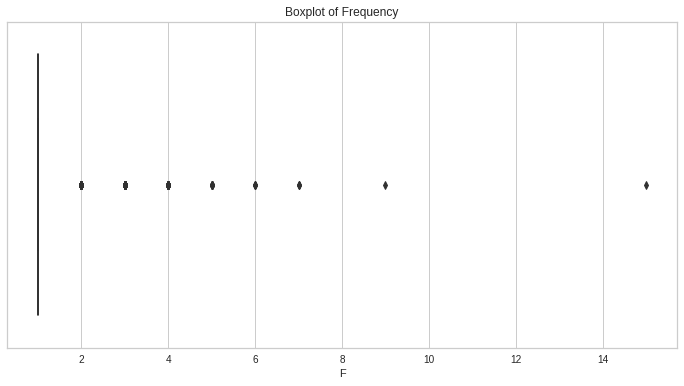

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='F', data=rfm_df)
plt.title('Boxplot of Frequency');

Hypothesis : 
* Clients order without creating an account ? 

### Monetary

From 'merge customer X order' we will only keep `order_id` `customer_id` and `customer_unique_id` for now. 

In [ ]:
merge_order_customer = merge_cust_orders.iloc[:,[0,1,-1]]
merge_order_customer

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...
93120,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a
93121,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660
93122,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30
93123,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c


In [ ]:
merge_order_customer['customer_unique_id'].value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
                                    ..
89c1a3e3c96c821f7a06d1f84670727b     1
b15d7932f83e90d95c5eb50113925038     1
48cfb1ec8875f03ad35e4b714d1450b3     1
5891450360108dc473afec34275d86f2     1
fa08098a16131e9dd1dec2dd17fd4ee8     1
Name: customer_unique_id, Length: 90164, dtype: int64

In [ ]:
customer_to_look_for = merge_order_customer['customer_unique_id'] == '8d50f5eadf50201ccdcedfb9e2ac8455'
merge_order_customer[customer_to_look_for]

,order_id,customer_id,customer_unique_id
2204,c2213109a2cc0e75d55585b7aaac6d97,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455
3452,23427a6bd9f8fd1b51f1b1e5cc186ab8,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455
4860,e3071b7624445af6e4f3a1b23718667d,0bf8bf19944a7f8b40ba86fef778ca7c,8d50f5eadf50201ccdcedfb9e2ac8455
10961,d3582fd5ccccd9cb229a63dfb417c86f,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455
17914,bf92c69b7cc70f7fc2c37de43e366173,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455
23306,6bdf325f0966e3056651285c0aed5aad,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455
31564,4f62d593acae92cea3c5662c76122478,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455
36980,b850a16d8faf65a74c51287ef34379ce,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455
55108,519203404f6116d406a970763ee75799,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455
62495,a1a6eadae352582010f449d8527b55f3,3414a9c813e3ca02504b8be8b2deb27f,8d50f5eadf50201ccdcedfb9e2ac8455


The only unique value in this table `merger_order_customer` is the `customer_unique_id`. Indeed for a one `customer_unique_id` we can have several `customer_id` and `order_id`

In [ ]:
payments_raw['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
                                    ..
f7a94ed5a5cf7c0680e0d3271163bb3f     1
59eaa904b3f0dbde2785ac1b27eccd18     1
5608ac7a2d4918bf9d1d1ee11fd5dab3     1
9f9df59d8852ad5630e576aa48249c26     1
e5c543adb388da035a48a7b7fd057f5a     1
Name: order_id, Length: 99440, dtype: int64

In [ ]:
order_to_look_for = payments_raw['order_id'] == 'fa65dad1b0e818e3ccc5cb0e39231352'
payments_raw[order_to_look_for].sort_values(by='payment_sequential')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


For each method of payment (in the example above, vouchers) we have a line of data. We therefore need to group by `order_id` to obtain the `order_value` per `order_id`

In [ ]:
monetary_by_order = payments_raw.groupby(by='order_id').sum()
monetary_by_order = monetary_by_order[['payment_value']]

monetary_by_order

,payment_value
order_id,
00010242fe8c5a6d1ba2dd792cb16214,72.19
00018f77f2f0320c557190d7a144bdd3,259.83
000229ec398224ef6ca0657da4fc703e,216.87
00024acbcdf0a6daa1e931b038114c75,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...
fffc94f6ce00a00581880bf54a75a037,343.40
fffcd46ef2263f404302a634eb57f7eb,386.53
fffce4705a9662cd70adb13d4a31832d,116.85


In [ ]:
merge_order_payment = monetary_by_order.merge(merge_order_customer[['order_id', 'customer_unique_id']], on = 'order_id')
merge_order_payment

,order_id,payment_value,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,259.83,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,216.87,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,25.78,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,64b576fb70d441e8f1b2d7d446e483c5
...,...,...,...
93120,fffc94f6ce00a00581880bf54a75a037,343.40,0c9aeda10a71f369396d0c04dce13a64
93121,fffcd46ef2263f404302a634eb57f7eb,386.53,0da9fe112eae0c74d3ba1fe16de0988b
93122,fffce4705a9662cd70adb13d4a31832d,116.85,cd79b407828f02fdbba457111c38e4c4
93123,fffe18544ffabc95dfada21779c9644f,64.71,eb803377c9315b564bdedad672039306


To obtain the `Monetary` KPI we need to group by `customer_unique_id` in order to have the average order amount per customer : 

In [ ]:
merge_order_payment = merge_order_payment.groupby('customer_unique_id')[['payment_value']].mean()
merge_order_payment

,payment_value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0000f46a3911fa3c0805444483337064,86.22
0000f6ccb0745a6a4b88665a16c9f078,43.62
0004aac84e0df4da2b147fca70cf8255,196.89
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
fffea47cd6d3cc0a88bd621562a9d061,84.58
ffff371b4d645b6ecea244b27531430a,112.46


In [ ]:
rfm_df = rfm_df.merge(merge_order_payment, left_index=True, right_index=True)

In [ ]:
rfm_df = rfm_df.rename({"payment_value":'M'}, axis=1)

In [ ]:
rfm_df

,order_purchase_timestamp,R,F,M
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115,1,27.19
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,447,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,262,1,84.58
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,568,1,112.46


In [ ]:
rfm_df.describe()

,R,F,M
count,90164.000000,90164.000000,90164.000000
mean,236.380884,1.032840,159.077784
std,151.946197,0.207759,218.678270
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,61.960000
50%,219.000000,1.000000,105.115000
75%,347.000000,1.000000,175.330000
max,602.000000,15.000000,13664.080000


## Clustering

###RFM Score

####Formula

To calculate RFM score we will use quantiles : 
* for Recency and Monetary : quantiles containing 1/3 of the population each
* for Frequency : regarding the distribution of the Frequency, we will split the items as follows : 
  * score=1 if the frequency value is 1
  * else : score=2

Using quantiles is more relevant when data is expected to change with time (compared to fixed thresholds). 

Here we noticed in our [EDA](https://colab.research.google.com/drive/11PtfRXOcoCF5OZfBv4Q1LcKO75U8z2Rv#scrollTo=Ly50d3vabFUf) that customer number strongly increase with time. Quantiles will therefore enable RFM score to adapt to the data : 

In [ ]:
rfm_df['R_score'] = pd.qcut(rfm_df['R'], 3, labels=[1, 2, 3]).astype('str')
rfm_df['M_score'] = pd.qcut(rfm_df['M'], 3, labels=[1, 2, 3]).astype('str')

rfm_df['F_score'] = rfm_df['F'].apply(lambda x: '1' if x==1 else '2')

In [ ]:
#Footing RFM score : 

rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']

In [ ]:
rfm_df.head()

,order_purchase_timestamp,R,F,M,R_score,M_score,F_score,RFM_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112,1,141.90,1,2,1,112
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115,1,27.19,1,1,1,111
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537,1,86.22,3,2,1,312
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321,1,43.62,3,1,1,311
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288,1,196.89,2,3,1,213


 The scoring obtained is consitent with our expectations. It should be red as follows : 
*  R score : 1 (best) to 3 (worse)
*  F score : 1 (worse) to 2 (best)
*  M score : 1 (worse) to 3 (best)


In [ ]:
rfm_df.loc['0000366f3b9a7992bf8c76cfdf3221e2']

order_purchase_timestamp    2018-05-10 10:56:27
R                                           112
F                                             1
M                                         141.9
R_score                                       1
M_score                                       2
F_score                                       1
RFM_score                                   112
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: object

In [ ]:
#Count number of segments (unique values)
distinct_values = len(set(rfm_df['RFM_score']))

print(f'We obtained {distinct_values} distinct segments based on our RFM score.')

We obtained 18 distinct segments based on our RFM score.


####Clusters Definition

Let's split in fewer segments based on Marketing knowledge : 

https://www.barilliance.com/rfm-analysis/#tab-con-3

Segment name  | Description | Marketing Strategies 
-------------------|------------------|------------------
1. CORE - Best Customers       | Highly engaged customers who have bought the most recent, the most often, and generated the most revenue.       | Focus on loyalty programs and new product introductions. These customers have proven to have a higher willingness to pay,<br /> so don't use discount pricing to generate incremental sales. <br />Instead, focus on value added offers through product recommendations based on previous purchases.
2. LOYAL - Your Most Loyal Customers  | Customers who buy the most often from your store.      | Loyalty programs are effective for these repeat visitors. Advocacy programs and reviews are also common strategies. <br />Lastly, consider rewarding these customers with Free Shipping or other like benefits.
3. WHALES - Your Highest Paying Customers      | Customers who have generated the most revenue for your store.      | These customers have demonstrated a high willingness to pay. <br />Consider premium offers, subscription tiers, luxury products, or value add cross/up-sells to increase AOV. <br />Don't waste margin on discounts. 
4. REGULAR - Faithful customers      | Customers who return often, but do not spend a lot.      | You've already succeeded in creating loyalty. <br />Focus on increasing monetization through product recommendations based on past purchases <br />and incentives tied to spending thresholds.
5. ROOKIES - Your Newest Customers      | First time buyers on your site.      | Most customers never graduate to loyal. <br />Having clear strategies in place for first time buyers <br />such as triggered welcome emails will pay dividends.
6. GONE - Once Loyal, Now Gone      | Great past customers who haven't bought in a while.      | Customers leave for a variety of reasons. <br />Depending on your situation price deals, new product launches, <br />or other retention strategies.



	
 	
	
	
	
	
	

	
	

In [ ]:
def segment(x):
    if x == '123':
        return 'Core'
    elif x in ['311', '312', '313', '211', '212']: #212 and 211 = severe appreciation of gone
        return 'Gone'
    elif x in ['111', '112', '113']:
        return 'Rookies'
    elif x in ['323', '213', '223']:
        return 'Whales'
    elif x in ['221', '222', '321', '322']:
        return 'Loyal'
    else:
        return 'Regular' #121 #122

In [ ]:
#apply function to define segments
rfm_df['segments'] = rfm_df['RFM_score'].apply(segment)

####Treemaps for results

In [ ]:
#Print results of segments
rfm_df['segments'].value_counts(normalize=True)*100

Gone       53.946143
Rookies    32.465285
Whales     11.226210
Loyal       1.287654
Regular     0.704272
Core        0.370436
Name: segments, dtype: float64

In [ ]:
rfm_groups = rfm_df.groupby('segments').agg(RecencyMean = ('R', 'mean'),
                                          FrequencyMean = ('F', 'mean'),
                                          MonetaryMean = ('M', 'mean'),
                                          GroupSize = ('R', 'size'))

rfm_groups

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segments,,,,
Core,73.047904,2.194611,271.292712,334
Gone,338.257627,1.000000,127.955765,48640
Loyal,307.323859,2.100775,84.392004,1161
Regular,74.031496,2.127559,86.252458,635
Rookies,74.259326,1.000000,164.344075,29272
Whales,223.104624,1.056115,302.833424,10122


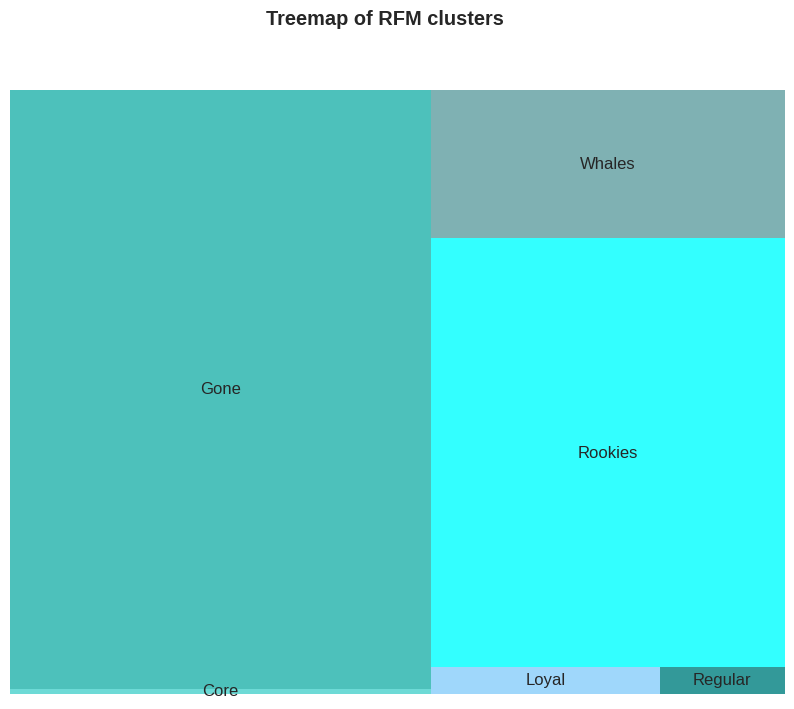

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

# plot a treemap to visualize RFM groups (df)
squarify.plot(sizes=rfm_groups['GroupSize'], 
              label=rfm_groups.index, 
              color = ['mediumturquoise', 'lightseagreen', 'lightskyblue', 'teal', 'aqua', 'cadetblue'],
              alpha=.8 )
plt.axis('off')

#Use suptitle to print bold title
plt.suptitle("Treemap of RFM clusters",fontweight='bold')
#plt.title('Treemap of RFM clusters')

plt.show()

You can create a treemap with colors mapped on values by using squarify and matplotlib libraries. In the following example, in order to map colors, `matplotlib.colors.Normalize()` is used with `vmin` and `vmax`, minimum values and maximum values respectively. Each value in `my_values` list is normalized and then map to a color.

[Link](https://www.python-graph-gallery.com/202-treemap-with-colors-mapped-on-values)

In [ ]:
rfm_groups_all = rfm_df.groupby('RFM_score').agg(GroupSize = ('RFM_score','size'))
rfm_groups_all

,GroupSize
RFM_score,
111,9487
112,9777
113,10008
121,244
122,391
123,334
211,10061
212,9369
213,9597


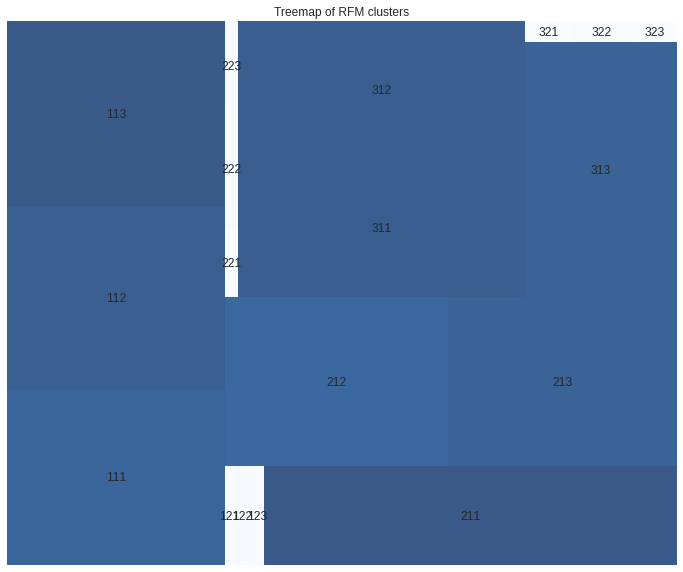

In [ ]:
plt.figure(figsize=(12, 10))

#Create a color palette, mapped with dataframe values
cmap = matplotlib.cm.Blues
mini = min(rfm_groups_all['GroupSize'])
maxi = max(rfm_groups_all['GroupSize'])
norm = matplotlib.colors.Normalize(vmin = mini, vmax=maxi)
colors = [cmap(norm(value)) for value in rfm_groups_all['GroupSize']]

# plot a treemap to visualize RFM groups (df)
squarify.plot(sizes= rfm_groups_all['GroupSize'],  
              color=colors,
              label=rfm_groups_all.index,
              alpha=.8 )
plt.axis('off')

plt.title('Treemap of RFM clusters')

plt.show()

Treemap with colors based on values are not rely relevant with few clusters of the same size. 

#Automating Clustering with ML

###Pre-processing

#### Select features

In [ ]:
#clone data
data = rfm_df

In [ ]:
data.shape[0]

90164

Let's drop scores that are not relevant for our clustering : 

In [ ]:
data.drop(['order_purchase_timestamp', 
           'F', 
           'R_score', 
           'M_score', 
           'F_score', 
           'RFM_score', 
           'segments'], axis=1, inplace=True)

Merge tables to get the relevant features : 

* **Actual Lead Time (days)** : Number of days taken to deliver a product to the customer, from the moment an order has been placed in the system. 
* **Monetary** : from KPI Calculation footed above ; 
* **Recency** : from KPI Calculation footed above ; 
* **review_score** : from field `review_score` in `olist_order_reviews_dataset.csv` ; 
* **Number of products bought** : from field `order_item_id` in `olist_order_items_dataset.csv`

About how K-means works : https://towardsdatascience.com/how-does-k-means-clustering-in-machine-learning-work-fdaaaf5acfa0


####Grouping Data

In [ ]:
#Merge Orders dataset and review dataset (to obtain review_score)
orders_raw_reviews = orders_raw.merge(reviews_raw, on='order_id')

In [ ]:
#Merge the obtained dataset with the order items dataset (to obtain items_id per order)

orders_raw_reviews_items = orders_raw_reviews.merge(order_items_raw, on='order_id')
orders_raw_reviews_items.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_day_of_week,order_purchase_day_of_week_name,order_purchase_hours,order_approved_date,order_delivery_carrier_date,order_delivery_customer_estimated,order_delivery_customer_date,placing_daylag,shipping_daylag,estimation_daylag,carrier_daylag,delivery_timing,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,Morning,20171002,20171004,20171018,20171010,0,2,-8,6,8,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,Evening,20180726,20180726,20180813,20180807,2,0,-6,81,13,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,Morning,20180808,20180808,20180904,20180817,0,0,-87,9,9,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18,2018-08-22 19:07:58,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [ ]:
#Group by customer id to obtain the aggregated features
#Using agg functions enables to use several group by methods (https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns)

orders_raw_reviews_items = orders_raw_reviews_items.groupby('customer_id').agg({'delivery_timing': 'mean', 
                                                                                'review_score':'mean', 
                                                                                'order_item_id':'sum'})
orders_raw_reviews_items

,delivery_timing,review_score,order_item_id
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,13,1.0,1.0
000161a058600d5901f007fab4c27140,9,4.0,1.0
0001fd6190edaaf884bcaf3d49edf079,5,5.0,1.0
0002414f95344307404f0ace7a26f1d5,28,5.0,1.0
000379cdec625522490c315e70c7a9fb,11,4.0,1.0
...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,4,5.0,1.0
fffecc9f79fd8c764f843e9951b11341,12,3.0,1.0
fffeda5b6d849fbd39689bb92087f431,17,4.0,1.0


In [ ]:
#Merge the obtained df with customer raw to obtain customer_unique_id
orders_reviews_items_unique = orders_raw_reviews_items.merge(customers_raw, on='customer_id')

In [ ]:
orders_reviews_items_unique.head()

,customer_id,delivery_timing,review_score,order_item_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,13,1.0,1.0,248ffe10d632bebe4f7267f1f44844c9,06273,osasco,SP
1,000161a058600d5901f007fab4c27140,9,4.0,1.0,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG
2,0001fd6190edaaf884bcaf3d49edf079,5,5.0,1.0,94b11d37cd61cb2994a194d11f89682b,29830,nova venecia,ES
3,0002414f95344307404f0ace7a26f1d5,28,5.0,1.0,4893ad4ea28b2c5b3ddf4e82e79db9e6,39664,mendonca,MG
4,000379cdec625522490c315e70c7a9fb,11,4.0,1.0,0b83f73b19c2019e182fd552c048a22c,04841,sao paulo,SP


In [ ]:
#Obtain final df with features expressed by customer_unique_id

#Merge data
data = data.merge(orders_reviews_items_unique, on='customer_unique_id', left_index=False, right_index=True)

#Select relevant features column
data = data[['R', 'M', 'delivery_timing', 'review_score', 'order_item_id']]

#Rename Columns
data.rename(columns={'R': 'recency', 'M': 'monetary'}, inplace=True)

data.head(3)

,recency,monetary,delivery_timing,review_score,order_item_id
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,141.90,6,5.0,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,27.19,3,4.0,1.0
0000f46a3911fa3c0805444483337064,537,86.22,25,3.0,1.0


In [ ]:
data = data.groupby('customer_unique_id').agg({'delivery_timing': 'mean', 
                                               'review_score':'mean', 
                                               'order_item_id':'sum',
                                               'recency' : 'mean',
                                               'monetary' : 'mean'
                                               })

In [ ]:
data.shape

(90164, 5)

Thanks to the previous we now have a grouped dataset. 

#### Removing Outliers

In [ ]:
# # #check for outliers
# for col in data.columns:
#   plt.figure()
#   sns.boxplot(data[col])

We first tried to remove outiers applying Z score rule (> 3). But as variables are not gaussians (cf [EDA Notebook](https://colab.research.google.com/drive/11PtfRXOcoCF5OZfBv4Q1LcKO75U8z2Rv#scrollTo=Ly50d3vabFUf)) we will rather us quantile selection method. 

In [ ]:
# # #remove outliers

# z = data.quantile(0.9)



# for col in data.columns:
#   # z = data.quantile(0,9)
#   # z = np.abs(stats.zscore(data[col]))
#   data_filtered = data[(z < 3)]
#   data_outliers = data[(z > 3)]
#   plt.figure()
#   sns.boxplot(data_filtered[col])
#   print(f'(Percentage outliers {col} : {data_outliers.shape[0] / data.shape[0] * 100}')
#   data = data_filtered

In [ ]:
data.shape

(90164, 5)

In [ ]:
#Better way to treat outliers

z = data.quantile(0.99) #return a series

#boolean to assess wether the value per column is below or equal to 99%
filter = data <= z 

#Filter using a boolean mask and check the results
data[filter].describe()

,delivery_timing,review_score,order_item_id,recency,monetary
count,89550.000000,90164.000000,89674.000000,89307.000000,89262.000000
mean,10.820129,4.211793,1.308428,233.070185,143.879043
std,6.403955,1.223482,1.034286,148.847329,136.000904
min,0.000000,1.000000,1.000000,0.000000,9.590000
25%,6.000000,4.000000,1.000000,112.000000,61.690000
50%,9.000000,5.000000,1.000000,217.000000,103.860000
75%,14.000000,5.000000,1.000000,343.000000,172.520000
max,31.000000,5.000000,10.000000,571.000000,1046.560000


In [ ]:
data = data[filter]

In [ ]:
z
data.describe()

,delivery_timing,review_score,order_item_id,recency,monetary
count,89550.000000,90164.000000,89674.000000,89307.000000,89262.000000
mean,10.820129,4.211793,1.308428,233.070185,143.879043
std,6.403955,1.223482,1.034286,148.847329,136.000904
min,0.000000,1.000000,1.000000,0.000000,9.590000
25%,6.000000,4.000000,1.000000,112.000000,61.690000
50%,9.000000,5.000000,1.000000,217.000000,103.860000
75%,14.000000,5.000000,1.000000,343.000000,172.520000
max,31.000000,5.000000,10.000000,571.000000,1046.560000


#### Missing Values

In [ ]:
data.isnull().values.any()

True

In [ ]:
data.isna().sum()

delivery_timing    614
review_score         0
order_item_id      490
recency            857
monetary           902
dtype: int64

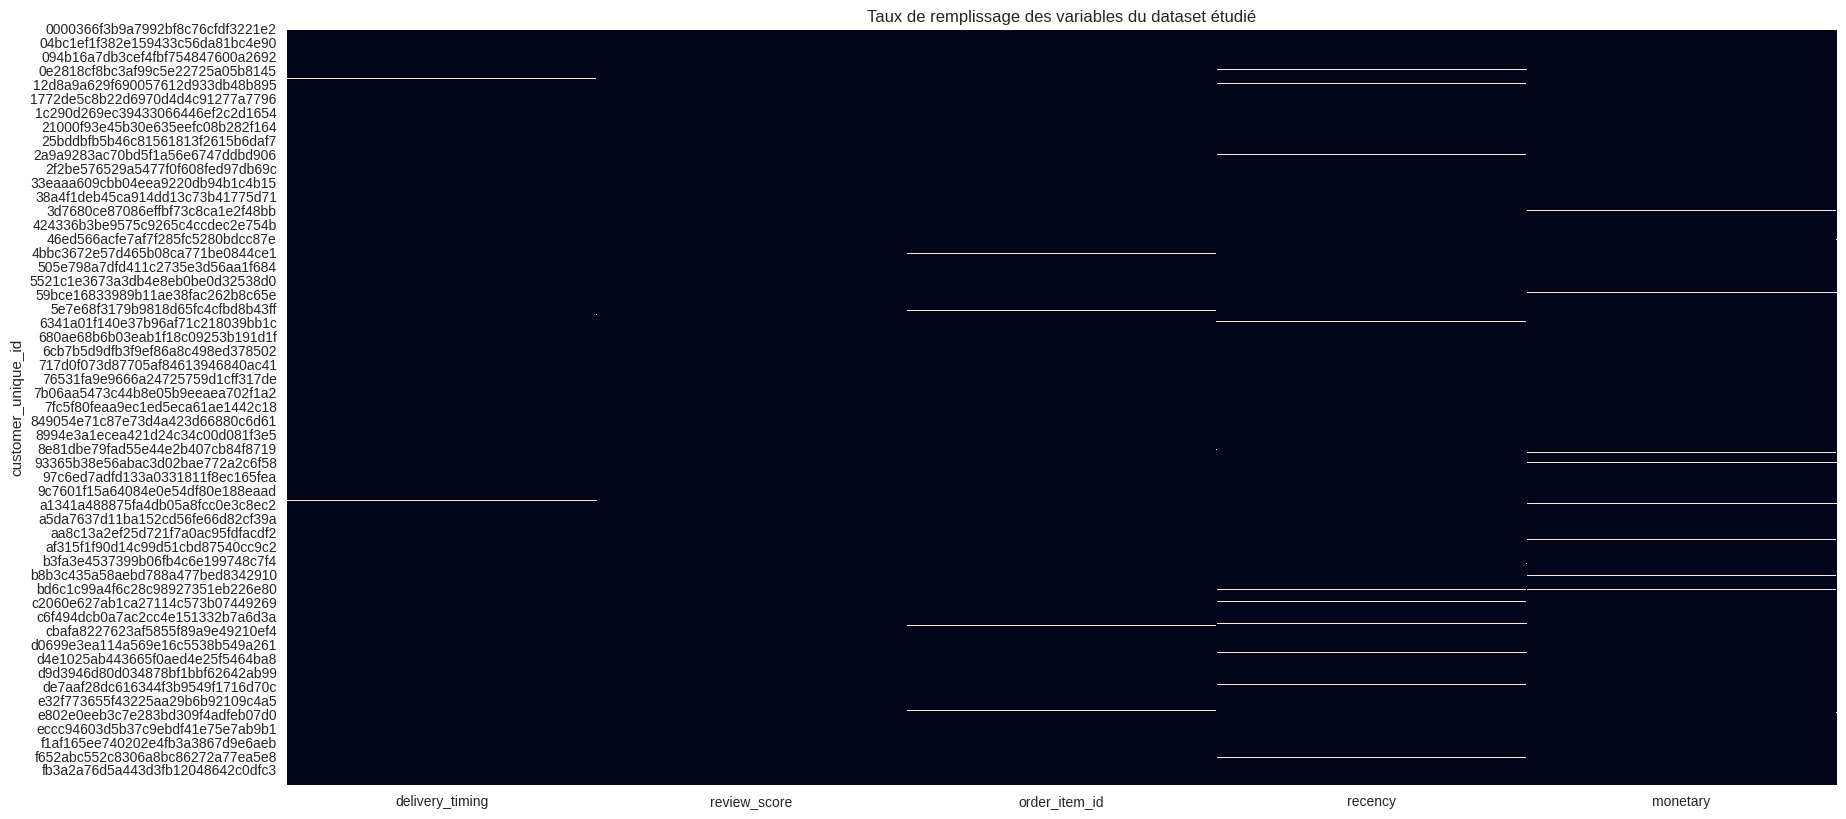

In [ ]:
plt.figure(figsize=(20,10), dpi=100)
plt.title('Taux de remplissage des variables du dataset étudié')
sns.heatmap(data.isna(), cbar=False)

We notice very few missing data. We will therefore choose to drop any missing data. 

In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
data.head()

,delivery_timing,review_score,order_item_id,recency,monetary
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,5.0,1.0,112.0,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,4.0,1.0,115.0,27.19
0000f46a3911fa3c0805444483337064,25.0,3.0,1.0,537.0,86.22
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,1.0,321.0,43.62
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,1.0,288.0,196.89


We will standardise the data with `MinMaxScaler()` - that we will prefer to `StandardScaler()` because of the non-gaussian feature that we are studying - to analyse potential relationships between them. 

####Scaling Data

In [ ]:
# print(scaler.__doc__)

In [ ]:
#Create Instance of Scaler
scaler = MinMaxScaler()

#Create copy of data (in case of error ;) )
df = data.copy()

#Fit Transform to scale
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

df.head()

,delivery_timing,review_score,order_item_id,recency,monetary
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.193548,1.00,0.0,0.196147,0.127593
0000b849f77a49e4a4ce2b2a4ca5be3f,0.096774,0.75,0.0,0.201401,0.016973
0000f46a3911fa3c0805444483337064,0.806452,0.50,0.0,0.940455,0.073898
0000f6ccb0745a6a4b88665a16c9f078,0.645161,0.75,0.0,0.562172,0.032817
0004aac84e0df4da2b147fca70cf8255,0.419355,1.00,0.0,0.504378,0.180622


In [ ]:
sns.pairplot(df)

### KMeans

####Build a Pipeline

We want to normalize the values so they have the same amplitude. 

In [ ]:
#Encoding check (i.e look for potential categorical features)
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

In [ ]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['delivery_timing', 'review_score', 'order_item_id', 'recency', 'monetary']

We prepare a pre-processor that we will add to a pipeline : 

In [ ]:
#Define the scaler to be applied - Create an instance of it : 

# scaler = StandardScaler() #Will be preferential when analysing gaussian variables
scaler = MinMaxScaler() #Divided by max, centered by min

#Use ColumnTransformer from Compose module of Scickit Learn
preprocessor = ColumnTransformer([('scaler', #name
                                   scaler, #instance to be applied
                                   numerical_features)]) #columns

####Yellowbrick for Silhouette Score and Best K

We will use the module **[Yellowbrick](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)**. 

This library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. It extends the scikit-learn API with a new core object: the `Visualizer`. 

Visualizers allow models to be fit and transformed as part of the scikit-learn pipeline process, providing visual diagnostics throughout the transformation of high-dimensional data.

Currently, Yellowbrick provides two visualizers to evaluate centroidal mechanisms, particularly K-Means clustering, that help users discover an optimal  K  parameter in the clustering metric:

* `KElbowVisualizer` visualizes the clusters according to a scoring function, looking for an "elbow" in the curve.
* `SilhouetteVisualizer` visualizes the silhouette scores of each cluster in a single model.

Create a pipeline and add : 
* Pre-processor : Standard Scaler of numerical features (i.e all features here)
* Kelbow visualizer : Elbow method to identify the optimal k value

In [ ]:
# print(preprocessor.__doc__)

In [ ]:
X = data.copy()

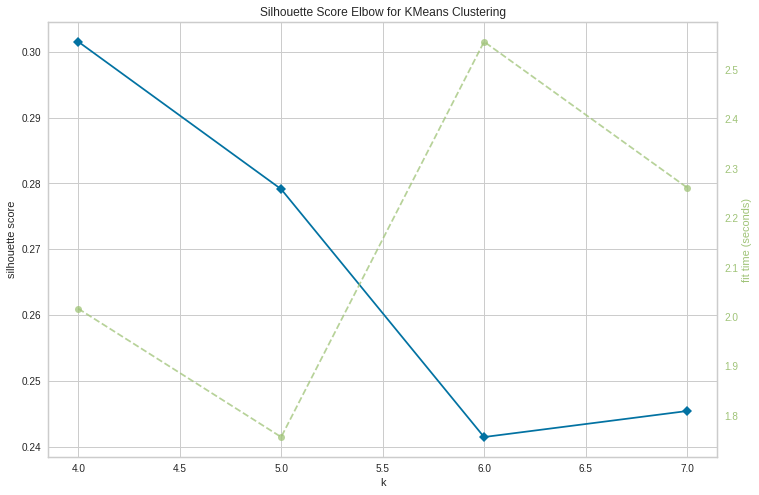

In [ ]:
model = KMeans()

#Elbow method to find optimal value of k : 
kmeans_visualizer = Pipeline([
                              ("preprocessor", preprocessor),
                              ("kelbowvisualizer", KElbowVisualizer(model,
                                                                    k=(4,8), 
                                                                    metric='silhouette',
                                                                    locate_elbow=False)
                              )
                              ])

kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

By default, the scoring parameter metric is set to `distortion`, which computes the sum of squared distances from each point to its assigned center.

We will prefer the silhouette score as a matter of consistency with the rest of the notebook. 

The Silhouette Coefficient is calculated using the `mean intra-cluster distance (a)` and the `mean nearest-cluster distance (b)` for each sample. 
* To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. 


The **Silhouette Coefficient** for a sample is `(b - a) / max(a, b)`. 


* The best value is 1 and the worst value is -1. 
* Values near 0 indicate overlapping clusters. 
* Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

([scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html))

In [ ]:
#Retrieve optimal value of k 
#from source code of the library : https://www.scikit-yb.org/en/latest/_modules/yellowbrick/cluster/elbow.html#kelbow_visualizer

#kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_ #since we set locate_elbow to False, it is not available


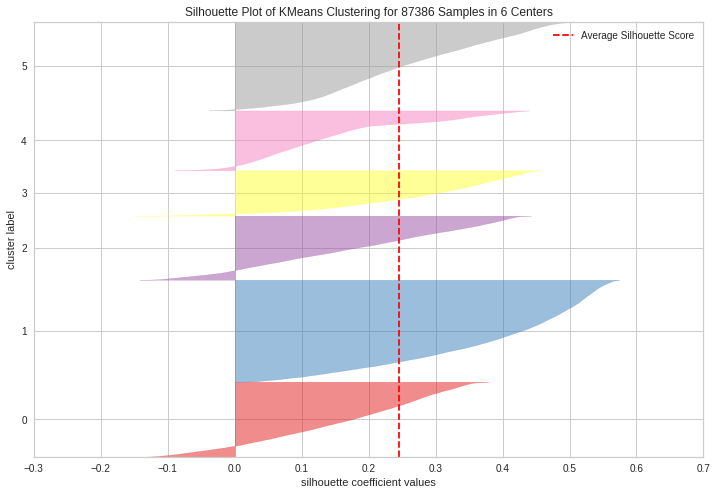

In [ ]:
# Best K in Elbow
#K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
K = 6

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])

silhouette_visualizer.fit(X)

silhouette_visualizer.named_steps['silhouettevisualizer'].show()

####Cluster Analysis

In [ ]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['delivery_timing',
                                                   'review_score',
                                                   'order_item_id', 'recency',
                                                   'monetary'])])),
                ('kmeans', KMeans(n_clusters=6))])

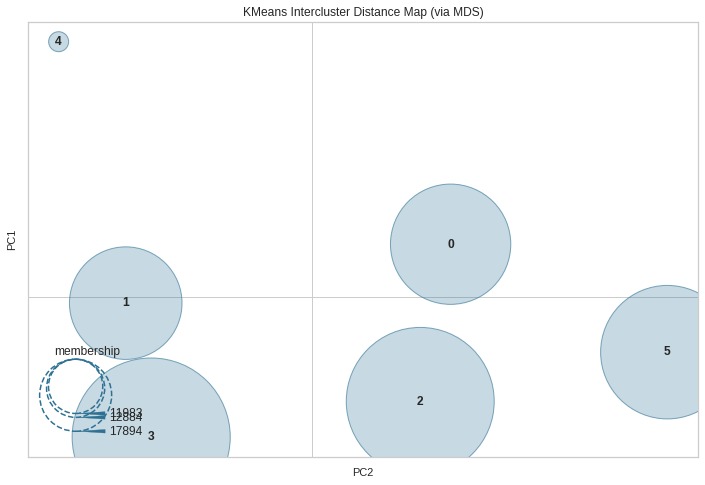

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

On this 2D projection, we notice that the different clusters are well separated on the first 2 principal components. The clustering seems to be efficient. Let's now identify the business components of each cluster.

In [ ]:
#Cluster statistical analysis
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_

#Group by cluster labels
data["kmeans_label"] = kmeans_labels
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,delivery_timing,review_score,order_item_id,recency,monetary
0,0,19.803735,4.583112,1.209518,216.947349,159.971127
1,1,9.069754,4.997855,1.253978,391.534391,138.570671
2,2,7.139294,4.996667,1.248110,108.643037,135.875607
3,3,14.207691,1.227627,1.732661,227.057910,162.165025
4,4,8.215819,3.662748,1.308089,117.011556,132.679392
5,5,10.666745,3.616380,1.313243,398.986340,135.203589


In [ ]:
#Parallel plot with plotly
#https://plotly.com/python/parallel-coordinates-plot/

fig = px.parallel_coordinates(kmeans_clusters_means, color="kmeans_label",
                              dimensions=['recency',
                                          'monetary',
                                          'delivery_timing',
                                          'review_score',
                                          'order_item_id'],
                              color_continuous_midpoint=2)
fig.show()

In [ ]:
#without resetting index
kmeans_clusters_means_ = data.groupby("kmeans_label").mean()

In [ ]:
#RadarPlot
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()

    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Features Mean Comparison Per Cluster",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [ ]:
kmeans_clusters_means.columns

Index(['kmeans_label', 'delivery_timing', 'review_score', 'order_item_id',
       'recency', 'monetary'],
      dtype='object')

In [ ]:
plot_radars(kmeans_clusters_means_,group='kmeans_label')

In [ ]:
# explication texte des segments + action commerciale

###Hierarchical Clustering

In [ ]:
#CAH / DBScan : travail de recherche hyperparams (par rapport au silhouette score) 
#--> Interpréter les segments (pour pouvoir les présetner au client)
#CAH : Ward distance (regroupement des observations via)
  #Distance quadratique : Prendre un sous-échantillon

In [ ]:
#Create a sample (as CAH is very resources consuming)
data_cah = data.sample(frac=0.05, replace=True, random_state=1)

We will use ward method to calculate distance between clusters. This method minimizes then variants of distances between the clusters.

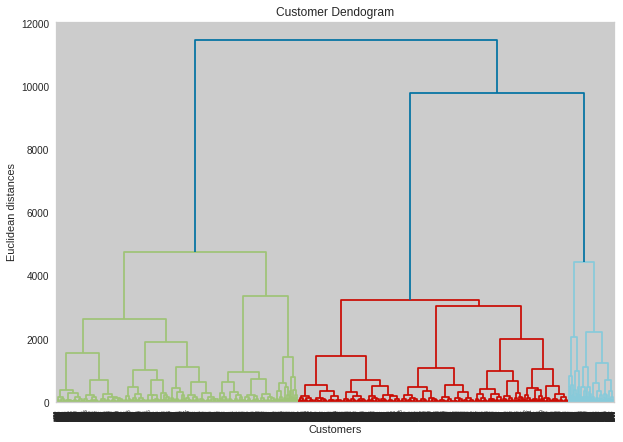

In [ ]:
#Plot dendogram
plt.figure(figsize=(10, 7))

dend = shc.dendrogram(shc.linkage(data_cah, method='ward'))

plt.title("Customer Dendogram")
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.show()
#ward : minimum variance method (i.e minimizes variance in clusters)

Optimal number of clusters can be find from the top, where we have the biggest vertical distance between horizontal bars.

In [ ]:
n_clusters_cah = 3

Training the Hierarchical Clustering model on the dataset

In [ ]:
hc = AgglomerativeClustering(n_clusters = n_clusters_cah, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(data_cah)

In [ ]:
#Cluster statistical analysis
hc_labels = hc.labels_

# #Group by cluster labels
data_cah["hc_labels"] = hc_labels
data_cah.drop(axis=1, columns='kmeans_label', inplace=True)

hc_clusters_means = data_cah.groupby("hc_labels").mean().reset_index()

In [ ]:
#graphical clusters interpretation
fig = px.parallel_coordinates(hc_clusters_means, color="hc_labels",
                              dimensions=['recency',
                                          'monetary',
                                          'delivery_timing',
                                          'review_score',
                                          'order_item_id'],
                              color_continuous_midpoint=2)
fig.show()

In [ ]:
hc_clusters_means = data_cah.groupby("hc_labels").mean()

plot_radars(hc_clusters_means,group='hc_labels')

In [ ]:
#Possibilité : utiliser CAH pour prédire sur une partie de la population (ici sample 5%) --> ça nous définit des labels 
#--> passer en mode supervisé et utiliser par exemple knn pour prédire sur l'ensemble de la population à partir des clusters définis par CAH. 

###DBSCAN

https://shritam.medium.com/how-dbscan-algorithm-works-2b5bef80fb3


DBSCAN : Density-based spatial clustering of applications with noise

DBSCAN algorithm basically requires 2 parameters:
* **eps**: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered to be neighbors.

* **minPoints**: the minimum number of points to form a dense region. For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region. It’s basically known as min_samples.

In [ ]:
#DBSCAN : Utilise la notion de densité pour regrouper les données
#cf Scikit Learn - faire varier l'epsilon

#=> Conclure sur la méthode à retenir

#epsilon : rayon (entre non-core et core sample)
#min_sample : nb min d'obs non périf nécessaires pr définir cluster

from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

#Les données sont très denses (peu de diff entre clusters). 
#Pas de forme particulière non plus (car par de phénomène géographique ou temporel derrière)

min_samples_var = np.linspace(5, 20, 5)
eps_var = np.linspace(0.5, 10, 10)

for min in min_samples_var:
  for eps in eps_var: 
    db = DBSCAN(eps=eps, min_samples=min).fit(X)
    
    print('epsilon: %0.1f' % eps)
    print('min_samples: %d' % min)

    # measure the performance of dbscan algo
    #calculating the number of clusters
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print('Estimated percentage of noise: %0.3f' % (n_noise_ / (X.shape[0])) if n_clusters_ !=0 else '100%')
    print('Silhouette Score: %0.3f \n' % metrics.silhouette_score(X, labels, metric='euclidean') if n_clusters_ > 1 else 'Single or No Cluster. No Silhouette Score can be footed.\n')
    
    #calculer score silhouette avec indiv en dehors de -1
    #calculer population bruit / pop globale
    #combinaison qui maximise score silhouette et min bruit


#important : possible de faire varier la distance à considérer 

#(possible ici d'encoder les variables catego puis de calculer une distance non euclidienne sur ces colonnes, 
#et euclidiennes sur les var numériques). 

#ON peut utiliser aussi K-prototype : https://antonsruberts.github.io/kproto-audience/#:~:text=K%2DPrototypes%20is%20a%20lesser,the%20number%20of%20matching%20categories.

#A la différence de K-means qui possède des paramètres appris (le prédict est donc possible). 
#DBSCAN et CAH procède de manière itérative pour obtenir les clusters, impossible donc de faire un predict (nécessaire de fit à chaque fois de)
#Alternative : Résultats de DBSCAN ou CAH utilisés pour définir des labels et transformer en pb supervisé. On peut alors entrainer un modèle sur cette base et prédire des nouvelles observations. 

#Astuce pour faire de la stratification avec variable temporelle : 
#Discrétiser la variable temporelle pour obtenir les catégories temporelles = encodage pour obtenir un identifiant unique
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html
#Puis faire un tirage (qcut), puis stratification  

epsilon: 0.5
min_samples: 5
Estimated number of clusters: 0
Estimated number of noise points: 87386
100%
Single or No Cluster. No Silhouette Score can be footed.

epsilon: 1.6
min_samples: 5
Estimated number of clusters: 610
Estimated number of noise points: 82682
Estimated percentage of noise: 0.946
Silhouette Score: -0.793 

epsilon: 2.6
min_samples: 5
Estimated number of clusters: 1525
Estimated number of noise points: 52087
Estimated percentage of noise: 0.596
Silhouette Score: -0.617 

epsilon: 3.7
min_samples: 5
Estimated number of clusters: 641
Estimated number of noise points: 27089
Estimated percentage of noise: 0.310
Silhouette Score: -0.794 

epsilon: 4.7
min_samples: 5
Estimated number of clusters: 335
Estimated number of noise points: 14613
Estimated percentage of noise: 0.167
Silhouette Score: -0.804 

epsilon: 5.8
min_samples: 5
Estimated number of clusters: 264
Estimated number of noise points: 8968
Estimated percentage of noise: 0.103
Silhouette Score: -0.723 

epsilon

KeyboardInterrupt: ignored

In [ ]:
#Cluster statistical analysis
db_labels = db.labels_

# #Group by cluster labels
data["db_labels"] = db_labels
db_clusters_means = data.groupby("db_labels").mean().reset_index()
db_clusters_means

##Stability Analysis

Initialisation stability (Warning : import Stabilité à l'initialisation (important de ne pas fixer random state en production pour permettre à l'algo de converger de façon optimale). 

In [ ]:
#Initial period of 12 months
data_init = custom.make_dataset(initial=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.36s


In [ ]:
orders = orders_raw.loc[orders_raw.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("Analysis period is {} months long.".format(time_delta))

Analysis period is 19 months long.


In [ ]:
K = 6

b : data

c : period

In [ ]:
# Kmeans on initial period (on data b0 --> train c0 i.e algo delivered to the client):
scaler = MinMaxScaler()
data_init = pd.DataFrame(scaler.fit_transform(data_init.values), columns=data_init.columns, index=data_init.index)

c0_cluster = Pipeline([("kmeans", KMeans(K, random_state=42))])
c0_cluster.fit(data_init)

Pipeline(steps=[('kmeans', KMeans(n_clusters=6, random_state=42))])

In [ ]:
custom.make_dataset(initial=False, period=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.46s


,delivery_timing,review_score,order_item_id,recency,monetary
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,25.0,3.0,1.0,332.0,86.22
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,1.0,116.0,43.62
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,1.0,83.0,196.89
0005e1862207bf6ccc02e4228effd9a0,4.0,4.0,1.0,338.0,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,16.0,3.0,1.0,203.0,29.00
...,...,...,...,...,...
fffb09418989a0dbff854a28163e47c6,8.0,5.0,1.0,50.0,73.16
fffbf87b7a1a6fa8b03f081c5f51a201,18.0,5.0,1.0,40.0,167.32
fffea47cd6d3cc0a88bd621562a9d061,30.0,4.0,1.0,57.0,84.58


In [ ]:
ari_score = []

for p in np.arange(1,(time_delta-12),1):
    # Create dataset for period
    data_period = custom.make_dataset(initial=False, 
                                   period=p)
    
    #Standardisation
    data_period = pd.DataFrame(scaler.transform(data_period.values), columns=data_period.columns, index=data_period.index)

    #Kmeans on b_period (on data b_period --> train c_period i.e algo fitted on the updated dataset):
    cPeriod_cluster = Pipeline([("kmeans", KMeans(K, random_state=42))])
    cPeriod_cluster.fit(data_period)
    bData_by_cPeriod = cPeriod_cluster.predict(data_period)

    #Kmeans on b_period with c0(on data b_period --> train c0 i.e algo delivered to the client):
    bData_by_c0 = c0_cluster.predict(data_period)
    
    #Calculate clustering obtained with c0 (i.e algo delivered to the client)
    #with clustering obtained with c_period (algo fitted on the updated dataset)
    ari_p = adjusted_rand_score(bData_by_c0, bData_by_cPeriod)
    ari_score.append([p,ari_p])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.50s
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.60s
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.66s
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
______________________________________________________
Dataset Creation in progress...
Time duration : 3.73s
Drive already mounted at /content/drive; to atte

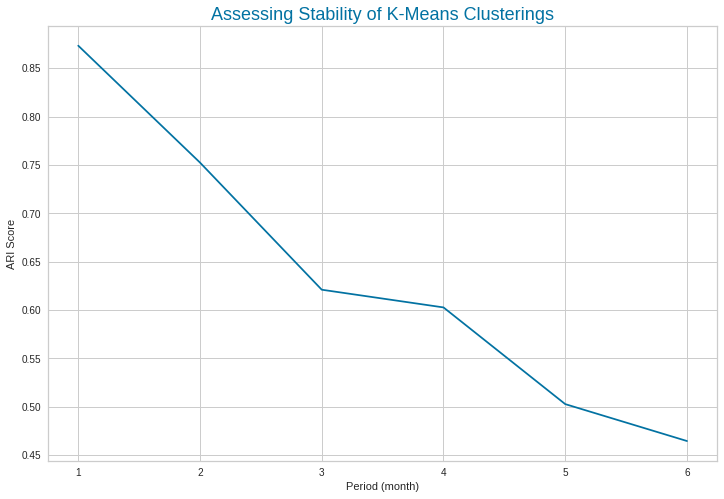

In [ ]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Period (month)")
plt.ylabel("ARI Score")
plt.title("Assessing Stability of K-Means Clusterings",
          fontsize=18,
          color="b")
plt.show()

In [ ]:
ari_score

,periode,ARI
0,1,0.873270
1,2,0.752402
2,3,0.620949
3,4,0.602642
4,5,0.502661
5,6,0.464487


CONCLUSION : 
The elbow observed on the ARI curve 
A maintenance should be performed every 3 months (training of the algo on the last dataset available) so that the clusters are aligned with 